# Project 2: ISS Pass Predictor & Logger

---

**Project Overview**
--

This project creates a personalized International Space Station (ISS) visibility tracker that predicts when the station passes overhead and maintains a historical log of observations. We'll use Skyfield for satellite predictions while building a Pandas-based database to track and analyze pass patterns over time.

**Key Features:**
- Download ISS TLE (Two-Line Element) data from Celestrak
- Predict visible passes for the next 7 days using Skyfield
- Store predictions in structured DataFrames
- Log actual observations with weather and viewing success data
- Analyze patterns using Pandas groupby operations
- Visualize pass frequencies and observation success rates
- Persist data to CSV files for cross-session continuity

**Astronomy Context:**
The International Space Station orbits Earth every ~90 minutes. A "pass" occurs when it flies overhead and becomes visible - appearing as a bright moving star. TLE data contains orbital parameters that enable software to predict satellite positions. Altitude refers to height above the horizon in degrees (0° = horizon, 90° = directly overhead). Passes above ~30° altitude are easiest to observe.

---

### Methodology

**Pathway B: Pandas + Astropy + Skyfield**
- **Skyfield**: Satellite orbit calculations and pass predictions
- **Pandas**: Data manipulation, filtering, and analysis
- **Astropy**: Astronomical coordinate transformations and constellation identification
- **Matplotlib**: Data visualization and plotting

**Data Pipeline:**
1. Acquire current ISS TLE data from Celestrak
2. Calculate visible passes for user location
3. Structure predictions in DataFrame format
4. Log observations with metadata
5. Merge predictions with observations
6. Analyze patterns and generate visualizations
7. Persist data for future sessions

https://github.com/vivianwang15637/astron_1221_proj_2.git

## 1. Project Setup, Dependencies, and Data Acquisition

This section establishes the foundation for our ISS tracking system by:
- Installing required dependencies
- Importing necessary libraries
- Configuring the observing location
- Acquiring current ISS orbital data
- Setting up data structures for predictions and observations

Let's begin by ensuring all required packages are available and properly imported.

### 1.1 Dependency Installation

**⚠️ IMPORTANT: Run this cell first before running any import cells!**

Before we can start predicting ISS passes, we need to install the required Python libraries. Each library serves a specific purpose in our project:

- **pandas**: Core data manipulation and analysis tool. We'll use this to store predictions in DataFrames, filter passes, and perform groupby operations.
- **numpy**: Numerical computing foundation that pandas is built upon.
- **matplotlib**: Visualization library for creating charts and plots of pass frequencies.
- **skyfield**: Specialized library for satellite orbit calculations and predicting when satellites are visible.
- **astropy**: Astronomical coordinate transformations for identifying constellations and working with celestial coordinates.
- **requests**: HTTP library for downloading TLE data from Celestrak website.

**Important Notes:**
- Run the installation cell below before proceeding to imports
- The installation may take 1-2 minutes depending on your internet connection
- Skyfield will automatically download ephemeris data (~10MB) on first use - this is normal
- If you get import errors, make sure you've run the installation cell and restarted the kernel

In [27]:
# Install all required packages
# Run this cell FIRST before any import statements!
# This command downloads and installs the libraries if they're not already present
%pip install pandas numpy matplotlib skyfield astropy requests

Note: you may need to restart the kernel to use updated packages.


### 1.2 Library Imports

**⚠️ Make sure you've run the installation cell above (Cell 3) before running this cell!**

Now that we have installed the packages, we need to import them into our notebook. Importing brings the library functions and classes into our current namespace so we can use them.

**If you get a `ModuleNotFoundError`:**
1. Go back and run Cell 3 (the installation cell)
2. Wait for installation to complete
3. Restart the kernel (Kernel → Restart)
4. Run Cell 3 again, then run this cell

**What we're importing:**
- Standard data science libraries (pandas, numpy, matplotlib)
- Date/time utilities for handling timestamps
- Skyfield classes for satellite tracking
- Astropy classes for astronomical coordinates


In [28]:
# Import all necessary libraries

# Standard Python libraries for data manipulation and web requests
import pandas as pd              # Primary tool for DataFrames and data analysis
import numpy as np               # Numerical computing (pandas dependency)
import requests                  # For downloading TLE data from Celestrak
import matplotlib.pyplot as plt  # For creating visualizations
from datetime import datetime, timedelta  # For handling dates and times
import warnings                  # To suppress non-critical warnings
warnings.filterwarnings('ignore')

# Skyfield imports - for satellite orbit calculations
from skyfield.api import load, EarthSatellite, Topos
# load: downloads ephemeris data
# EarthSatellite: represents a satellite with TLE data
# Topos: represents an observer location on Earth

# Astropy imports - for astronomical coordinate transformations
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_constellation
from astropy import units as u   # Physical units (degrees, meters, etc.)
from astropy.time import Time    # Time handling for astronomical calculations

print("All libraries imported successfully!")


All libraries imported successfully!


### 1.3 Define Observing Location

To predict when the ISS will be visible, we need to know our location on Earth. The ISS pass predictions depend on where we're observing from - different locations see the ISS at different times.

For this project, we'll use **Columbus, Ohio** as our default location. You can easily change the coordinates below to your own location.

**What we need:**
- **Latitude**: Distance north or south of equator (positive = north, negative = south)
- **Longitude**: Distance east or west of prime meridian (positive = east, negative = west)  
- **Elevation**: Height above sea level in meters (affects horizon calculations)

**Why this matters**: The ISS orbits at ~400km altitude, but passes appear different depending on our location. A pass visible from Ohio might not be visible from California!

In [29]:
# Step 1: Define geographic coordinates
# Columbus, Ohio coordinates
latitude = 39.9612    # North latitude in degrees (positive = north of equator)
longitude = -82.9988  # West longitude in degrees (negative = western hemisphere)
elevation = 275       # Elevation above sea level in meters

print("Observing Location Configuration:")
print(f"  Latitude: {latitude}° N")
print(f"  Longitude: {abs(longitude)}° W")  # Display as positive for clarity
print(f"  Elevation: {elevation} m above sea level")
print()

# Step 2: Create Skyfield observer object
# Topos() creates a location object that Skyfield uses for calculations
observer = Topos(latitude, longitude, elevation_m=elevation)
print("Observer location object created")

Observing Location Configuration:
  Latitude: 39.9612° N
  Longitude: 82.9988° W
  Elevation: 275 m above sea level

Observer location object created


### 1.4 Load Skyfield Timescale and Ephemeris Data

Skyfield needs two types of data files to make accurate predictions:

1. **Timescale**: A system for handling dates and times in astronomical calculations. It accounts for things like leap seconds and different time systems (UTC, etc.)

2. **Ephemeris Data**: A table of precise positions for celestial bodies (Earth, Sun, Moon, planets). This allows Skyfield to calculate exactly where satellites will appear in the sky.

**Note**: On first run, Skyfield will automatically download the ephemeris file (~10MB). This only happens once - subsequent runs use the cached file.


In [30]:
# Step 1: Load Skyfield timescale
# The timescale object handles time conversions for astronomical calculations
print("Loading Skyfield timescale...")
ts = load.timescale()
print("✓ Timescale loaded successfully")
print()

# Step 2: Load ephemeris data
# This downloads JPL DE421 ephemeris (~10MB) on first run
# The ephemeris contains precise positions of Earth, Sun, Moon, and planets
print("Loading ephemeris data (this may download ~10MB on first run)...")
eph = load('de421.bsp')
print("Ephemeris data loaded successfully")

print("\n" + "="*50)
print("Location and astronomical data setup complete!")
print("="*50)


Loading Skyfield timescale...
✓ Timescale loaded successfully

Loading ephemeris data (this may download ~10MB on first run)...
Ephemeris data loaded successfully

Location and astronomical data setup complete!


### 1.5 Acquire TLE Data for the ISS

**What is TLE Data?**

TLE (Two-Line Element) data is a standardized format that contains all the information needed to predict a satellite's position. Think of it as a "snapshot" of the satellite's orbit at a specific moment in time.

**Key facts about TLE data:**
- **Format**: Three lines - satellite name, then two lines of orbital parameters
- **Updated regularly**: ISS TLE data is updated daily because orbits decay slightly over time
- **Contains**: Orbital inclination, altitude, speed, and other parameters
- **ISS NORAD ID**: 25544 (a unique identifier assigned by the North American Aerospace Defense Command)

**Why we need it**: Without current TLE data, our predictions would be inaccurate. The ISS orbit changes slightly each day due to atmospheric drag, so we need fresh data from Celestrak (a trusted source for satellite tracking data).

In [31]:
# Step 1: Set up the URL for downloading TLE data
# Celestrak provides free, regularly-updated TLE data for all satellites
tle_url = "https://celestrak.org/NORAD/elements/gp.php?CATNR=25544"
print("Downloading ISS TLE data from Celestrak...")
print(f"Source: {tle_url}")
print()

# Step 2: Download the TLE data file
try:
    # Make HTTP request to download the file
    response = requests.get(tle_url)
    # Check if download was successful (status code 200 = success)
    response.raise_for_status()
    
    # Step 3: Parse the downloaded text
    # TLE files are plain text with each satellite's data on 3 lines
    tle_lines = response.text.strip().split('\n')
    print(f"Downloaded {len(tle_lines)} lines of TLE data")
    
    # Step 4: Find ISS data in the file
    # We search for lines containing "ISS" or the NORAD ID "25544"
    iss_tle = None
    for i, line in enumerate(tle_lines):
        if 'ISS' in line or '25544' in line:
            # ISS TLE format: name (line i), TLE line 1 (line i+1), TLE line 2 (line i+2)
            if i + 2 < len(tle_lines):
                iss_tle = tle_lines[i:i+3]
                break
    
    # Step 5: Process the ISS TLE data
    if iss_tle:
        print("\n✓ ISS TLE data found and downloaded successfully")
        print(f"  Satellite name: {iss_tle[0].strip()}")
        print(f"  TLE line 1: {iss_tle[1].strip()[:70]}...")  # Show first part
        print(f"  TLE line 2: {iss_tle[2].strip()[:70]}...")
        
        # Create a Skyfield EarthSatellite object from the TLE data
        # This object will be used for all our pass calculations
        satellite = EarthSatellite(iss_tle[1], iss_tle[2], iss_tle[0], ts)
        print("\nISS satellite object created - ready for calculations!")
        
    else:
        # If ISS not found, something went wrong
        print("\n✗ Error: ISS TLE data not found in downloaded file")
        raise ValueError("ISS data not found")
        
except (requests.exceptions.RequestException, ValueError) as e:
    # Step 6: Handle errors gracefully with fallback data
    print(f"\n✗ Error downloading/parsing TLE data: {e}")
    print("Using fallback TLE data (may be outdated, but allows testing)...")
    
    # Fallback TLE data structure (placeholder values)
    # In real use, this allows the notebook to run even if network fails
    fallback_tle = [
        "ISS (ZARYA)",
        "1 25544U 98067A   24123.12345678  .00001234  00000-0  12345-4 0  9999",
        "2 25544  51.6400 123.4567 0001234 123.4567 234.5678 15.12345678901234"
    ]
    
    satellite = EarthSatellite(fallback_tle[1], fallback_tle[2], fallback_tle[0], ts)
    print("Fallback satellite object created (for testing purposes)")

print("\n" + "="*50)
print("TLE data acquisition complete!")
print("="*50)

Source: https://celestrak.org/NORAD/elements/gp.php?CATNR=25544

Downloaded 3 lines of TLE data

✓ ISS TLE data found and downloaded successfully
  Satellite name: ISS (ZARYA)
  TLE line 1: 1 25544U 98067A   25308.35786713  .00010709  00000+0  19707-3 0  9991...
  TLE line 2: 2 25544  51.6336 332.4903 0005031  16.0382 344.0765 15.49743270536903...

ISS satellite object created - ready for calculations!

TLE data acquisition complete!


## 2. Core Prediction Pipeline and Data Wrangling

This section implements the Skyfield pass calculation and structures the output into a Pandas DataFrame. We'll:

1. Calculate all visible ISS passes for the next 7 days
2. Extract key information: rise time, max altitude, duration, brightness
3. Store everything in a DataFrame for easy analysis
4. Filter passes by altitude threshold (passes above 30° are easiest to see)

**Key Concepts:**
- A "pass" is when the ISS rises above the horizon, reaches maximum altitude, and sets
- We'll calculate passes where the ISS reaches at least 10° altitude (visible above the horizon)
- Duration is how long the pass lasts from rise to set
- Max altitude tells us how high the ISS appears in the sky

### 2.1 Function to Calculate Visible Passes

This is the core function that predicts when the ISS will be visible. It uses Skyfield's `find_events()` method to detect when the satellite rises above the horizon, reaches its highest point, and sets below the horizon.

**How it works:**
1. Skyfield calculates the ISS position at many time points
2. It detects when altitude crosses our minimum threshold (e.g., 10°)
3. For each complete pass, it records:
   - **Rise time**: When ISS first appears above horizon
   - **Max altitude time**: When ISS reaches highest point
   - **Set time**: When ISS disappears below horizon
   - **Max altitude**: How high in degrees (0° = horizon, 90° = overhead)
   - **Duration**: Total time from rise to set in minutes
   - **Brightness**: Apparent magnitude (lower number = brighter star)

**What we extract for each pass:**
- Rise time → when to start watching
- Max altitude → how high ISS will appear (higher = easier to see)
- Duration → how long we have to observe
- Brightness → how bright it will appear (depends on distance and solar angle)

The function returns a list of dictionaries, where each dictionary contains information about one pass.

In [32]:
def calculate_visible_passes(satellite, observer_location, start_time, days=7, min_altitude=10.0):
    """
    Calculate all visible ISS passes for a specified time period.
    
    This function uses Skyfield to find when the ISS rises above the horizon,
    reaches its highest point (culmination), and sets below the horizon. For
    each complete pass, it extracts key information like timing, altitude, and brightness.
    
    Parameters:
    -----------
    satellite : skyfield.api.EarthSatellite
        The ISS satellite object created from TLE data
    observer_location : skyfield.toposlib.Topos
        The observer's location on Earth (created from latitude/longitude)
    start_time : skyfield.timelib.Time
        When to start searching for passes (usually current time)
    days : float, optional
        How many days ahead to calculate passes (default: 7)
    min_altitude : float, optional
        Minimum altitude in degrees above horizon to consider (default: 10.0)
        Passes below this won't be included (helps filter out very low passes)
    
    Returns:
    --------
    list of dict
        Each dictionary contains:
        - 'rise_time': datetime when ISS appears above horizon
        - 'max_alt_time': datetime when ISS reaches highest point
        - 'set_time': datetime when ISS disappears below horizon
        - 'max_altitude': float, highest altitude in degrees (0-90)
        - 'duration_minutes': float, total pass duration
        - 'brightness': float, apparent magnitude (lower = brighter)
    
    Example:
    --------
    >>> passes = calculate_visible_passes(satellite, observer, ts.now(), days=7)
    >>> print(f"Found {len(passes)} passes")
    """
    
    # Step 1: Calculate the end time for our search window
    end_time = start_time + days
    
    # Step 2: Use Skyfield to find all rise/culminate/set events
    # find_events() returns:
    #   - t: array of times when events occur
    #   - events: array of event types (0=rise, 1=culminate, 2=set)
    # Events are only recorded when altitude crosses min_altitude threshold
    t, events = satellite.find_events(observer_location, start_time, end_time, altitude_degrees=min_altitude)
    
    # Step 3: Initialize list to store pass information
    passes = []
    
    # Step 4: Loop through events and group them into complete passes
    # Each complete pass has 3 events in order: rise (0), culminate (1), set (2)
    i = 0
    while i < len(events):
        # Check if we have a complete pass sequence (rise -> culminate -> set)
        if i + 2 < len(events) and events[i] == 0 and events[i+1] == 1 and events[i+2] == 2:
            
            # Extract the three key times for this pass
            rise_time = t[i]        # When ISS first appears
            max_alt_time = t[i+1]    # When ISS is highest
            set_time = t[i+2]       # When ISS disappears
            
            # Step 5: Calculate pass duration
            # Skyfield times are in days, so convert to minutes
            duration_minutes = (set_time - rise_time) * 24 * 60
            
            # Step 6: Calculate maximum altitude (how high ISS appears)
            # We need the satellite's position relative to our location
            difference = satellite - observer_location  # Relative position vector
            topocentric = difference.at(max_alt_time)    # Position at culmination time
            alt, az, distance = topocentric.altaz()     # Get altitude, azimuth, distance
            max_altitude = alt.degrees                   # Convert to degrees
            
            # Step 7: Estimate brightness (apparent magnitude)
            # Brightness depends on: distance to ISS, solar phase angle, ISS size
            # This is a simplified approximation - real calculations are more complex
            # ISS magnitude typically ranges from -2 (very bright) to +3 (dim)
            distance_km = distance.km
            brightness = 0.0 - (400 / distance_km)  # Closer ISS = brighter (lower number)
            
            # Step 8: Store all information about this pass in a dictionary
            pass_info = {
                'rise_time': rise_time.utc_datetime(),      # Convert to Python datetime
                'max_alt_time': max_alt_time.utc_datetime(),
                'set_time': set_time.utc_datetime(),
                'max_altitude': round(max_altitude, 2),     # Round to 2 decimal places
                'duration_minutes': round(duration_minutes, 1),  # Round to 1 decimal
                'brightness': round(brightness, 2)         # Round to 2 decimal places
            }
            
            passes.append(pass_info)
            i += 3  # Move to next potential pass (skip the 3 events we just processed)
        else:
            i += 1  # Skip incomplete events (if rise/culminate/set don't match)
    
    return passes

# Set up time period: next 7 days from now
now = ts.now()
print(f"Calculating passes starting from: {now.utc_datetime()}")
print(f"Looking ahead: 7 days")
print("="*50)

# Calculate all visible passes
all_passes = calculate_visible_passes(satellite, observer, now, days=7)

print(f"Found {len(all_passes)} visible passes in the next 7 days!")
print("="*50)


Calculating passes starting from: 2025-11-04 17:02:08.599576+00:00
Looking ahead: 7 days
Found 42 visible passes in the next 7 days!


Now let's call our function to calculate all visible passes for the next 7 days. We'll start from the current time and look ahead 7 days.


### 2.2 Store Predictions in DataFrame

Now we'll convert our list of passes into a Pandas DataFrame. This makes it easy to:
- View all passes in a table
- Filter passes by altitude
- Analyze patterns
- Save to CSV for later use

We'll create a DataFrame with all the pass information, then filter for passes above 30° altitude (easiest to see).


In [33]:
# Convert list of passes to a DataFrame, Add pass_ID to each for comparison to actual passes later
predictions_df = pd.DataFrame(all_passes)
predictions_df['pass_id'] = range(1, len(predictions_df) + 1)

# Display basic info about our DataFrame
print("Pass Predictions DataFrame:")
print(f"Total passes found: {len(predictions_df)}")
print("\nFirst few passes:")
print(predictions_df.head())

print("\n" + "="*50)
print("DataFrame Info:")
print(predictions_df.info())
print(predictions_df)
print("="*50)


Pass Predictions DataFrame:
Total passes found: 42

First few passes:
                         rise_time                     max_alt_time  \
0 2025-11-05 01:46:25.215189+00:00 2025-11-05 01:47:48.052278+00:00   
1 2025-11-05 03:20:49.268354+00:00 2025-11-05 03:24:08.350155+00:00   
2 2025-11-05 04:59:09.360391+00:00 2025-11-05 05:01:23.066646+00:00   
3 2025-11-05 06:38:02.439857+00:00 2025-11-05 06:39:14.201648+00:00   
4 2025-11-05 08:14:15.731013+00:00 2025-11-05 08:16:58.220375+00:00   

                          set_time  max_altitude  duration_minutes  \
0 2025-11-05 01:49:11.207610+00:00         12.09               2.8   
1 2025-11-05 03:27:28.785318+00:00         70.72               6.7   
2 2025-11-05 05:03:37.133149+00:00         16.43               4.5   
3 2025-11-05 06:40:25.926103+00:00         11.43               2.4   
4 2025-11-05 08:19:40.512997+00:00         21.99               5.4   

   brightness  pass_id  
0       -0.29        1  
1       -0.91        2  
2      

### 2.3 Filter Passes by Altitude Threshold

Passes above 30° altitude are easiest to see because they're high in the sky and above most obstructions. We'll filter our DataFrame to show only these "good" passes.

In [34]:
# Filter passes by altitude threshold (30 degrees = easiest to see)
altitude_threshold = 30.0

# Use Pandas to filter: only keep passes where max_altitude >= threshold
good_passes_df = predictions_df[predictions_df['max_altitude'] >= altitude_threshold]

print(f"Filtering passes above {altitude_threshold}° altitude...")
print(f"Total passes: {len(predictions_df)}")
print(f"Good passes (above {altitude_threshold}°): {len(good_passes_df)}")
print("\nBest viewing opportunities:")
print(good_passes_df[['rise_time', 'max_altitude', 'duration_minutes', 'brightness']].head(10))

print("\n" + "="*50)
print("Filtering complete!")
print("="*50)

Filtering passes above 30.0° altitude...
Total passes: 42
Good passes (above 30.0°): 14

Best viewing opportunities:
                          rise_time  max_altitude  duration_minutes  \
1  2025-11-05 03:20:49.268354+00:00         70.72               6.7   
5  2025-11-05 09:50:38.563456+00:00         59.75               6.6   
6  2025-11-06 02:32:41.983109+00:00         64.95               6.6   
10 2025-11-06 09:02:27.203682+00:00         76.51               6.7   
12 2025-11-07 01:44:49.534839+00:00         34.94               6.1   
16 2025-11-07 08:14:20.634466+00:00         44.77               6.5   
19 2025-11-08 02:33:09.899796+00:00         43.76               6.4   
23 2025-11-08 09:02:58.272875+00:00         34.42               6.2   
25 2025-11-09 01:44:47.138795+00:00         74.86               6.7   
29 2025-11-09 08:14:34.915298+00:00         63.66               6.6   

    brightness  
1        -0.91  
5        -0.83  
6        -0.87  
10       -0.92  
12       -0.58  

**Observation Log and Merge**

We define the structure of the observation log (observations.csv), create a dummy dataset, and merge it with the predictions. Add in your obervations into observations_df following format of observation. Afters you edit and run this cell you will get a .csv file you your obervations.

 Note: This is all hard coded so you must know exact pass_id you are observing based on the predictions, else it will merge incorrectly and be inaccurate. This serves on the assumption you are choosing a specific predicted observation to observe and then adding in the actual observation when corresponding the time and date comes. User input version is very basic and is commented out.

In [35]:
# def log_observation():
#     """
#     Observation logger
#     """
#     try:
#         # Load existing observations
#         observations_df = pd.read_csv('iss_observations.csv')
#     except FileNotFoundError:
#         # Create new if no exisiting is found
#         observations_df = pd.DataFrame(columns=[
#             'pass_id', 'observation_time', 'weather', 'successful', 'notes', 'actual_altitude'
#         ])
    
#     print("Enter observation: pass_id,datetime,weather,successful,notes,actual_altitude (Do NOT use commas other than to serpeate values)")
#     user_input = input("> ")
    
#     parts = [part.strip() for part in user_input.split(',')]
    
#     # Parse input
#     pass_id = int(parts[0])
#     observation_time = datetime.strptime(parts[1].strip(), "%Y-%m-%d %H:%M:%S")
#     weather = parts[2]
#     successful = parts[3].lower() == 'true'
#     notes = parts[4] if len(parts) > 4 else ""
#     actual_altitude = float(parts[5]) if len(parts) > 5 and parts[5] else None
    
#     # Create and save observation
#     observation = {
#         'pass_id': pass_id,
#         'observation_time': observation_time,
#         'weather': weather,
#         'successful': successful,
#         'notes': notes,
#         'actual_altitude': actual_altitude
#     }
    
#     new_obs = pd.DataFrame([observation])
#     observations_df = pd.concat([observations_df, new_obs], ignore_index=True)
#     observations_df.to_csv('iss_observations.csv', index=False)
    
#     print("Observation saved!")
#     observations_df

# # 1. Create observation, continuously prompt user for observations until invalid input
# has_obs = True
# while has_obs:
#     continue_input = input("Enter 'yes' to log an observation, else to quit: ").strip().lower()
#     if continue_input in ['yes', 'y']:
#         log_observation()   # Prompt user for observation(s)
#     else: 
#         has_obs = False
#         print("Thank you, goodbye.")

def log_observation(self, pass_id: int, weather: str, successful: bool, 
                       notes: str = "", actual_altitude: float = None):
    """
    Log an actual observation
        
    Args:
        pass_id: ID of the predicted pass
        weather: Weather conditions
        successful: Whether viewing was successful
        notes: Additional observations
        actual_altitude: Measured altitude if different from prediction
    """
    observation = {
        'pass_id': pass_id,
        'observation_time': datetime.now(),
        'weather': weather,
            'successful': successful,
            'notes': notes,
            'actual_altitude': actual_altitude
    }
        
    new_obs = pd.DataFrame([observation])
    self.observations_df = pd.concat([self.observations_df, new_obs], ignore_index=True)
    self.save_data()

# 1. Create observations, hard coded, so change to your actual observation, pass_id is self calculated based on date time and predicted time
observations_df = pd.DataFrame([
        {
        'pass_id': 1,
        'observation_time': datetime(2025, 11, 5, 1, 50, 15),
        'weather': 'Clear',
        'successful': True,
        'notes': 'Excellent visibility; stable tracking.',
        'actual_altitude': 69.1
    },
    {
        'pass_id': 2,
        'observation_time': datetime(2025, 11, 5, 3, 24, 10),
        'weather': 'Partly Cloudy',
        'successful': True,
        'notes': 'Minor interference due to low clouds.',
        'actual_altitude': 20.1
    },
    {
        'pass_id': 3,
        'observation_time': datetime(2025, 11, 5, 5, 29, 30),
        'weather': 'Overcast',
        'successful': False,
        'notes': 'Signal lost briefly; partial data recovered.',
        'actual_altitude': 10.9
    }
], columns=['pass_id', 'observation_time', 'weather', 'successful', 'notes', 'actual_altitude'])

# 2. Merge
merged_df = pd.merge(predictions_df, observations_df, on='pass_id', how='left')

# 3. Analyze
print("Observation analysis:")
print("Success rate:", merged_df['successful'].mean())
print("By weather:\n", merged_df.groupby('weather')['successful'].mean())

# 4. Save
observations_df.to_csv('iss_observations.csv', index=False)

Observation analysis:
Success rate: 0.6666666666666666
By weather:
 weather
Clear            1.0
Overcast         0.0
Partly Cloudy    1.0
Name: successful, dtype: object


**Analysis, Visualization, and Conclusion**
--
This section fulfills the analysis, visualization, and persistence requirements.

---

**Analysis: Pass Frequency per Day**

We analyze the frequency of passes over the next 7 days, which is a key requirement. Using the python statement below to do this:
```python
daily_passes = predictions_df['rise_time'].dt.date.value_counts().sort_index()


In [36]:
# Analyze pass frequency per day

# Extract date from rise_time and count passes per day
daily_passes = predictions_df['rise_time'].dt.date.value_counts().sort_index()

print("Passes per day:")
for date, count in daily_passes.items():
    print(f"  {date}: {count} passes")

print(f"\nTotal passes in {len(daily_passes)} days: {len(predictions_df)}")
print(f"Average passes per day: {len(predictions_df)/len(daily_passes):.1f}")

Passes per day:
  2025-11-05: 6 passes
  2025-11-06: 6 passes
  2025-11-07: 6 passes
  2025-11-08: 6 passes
  2025-11-09: 6 passes
  2025-11-10: 6 passes
  2025-11-11: 6 passes

Total passes in 7 days: 42
Average passes per day: 6.0


**Visualization: Pass Frequencies (Bar Chart)**

A bar chart visualizing the number of passes per day. Plotted based off code in previous block.

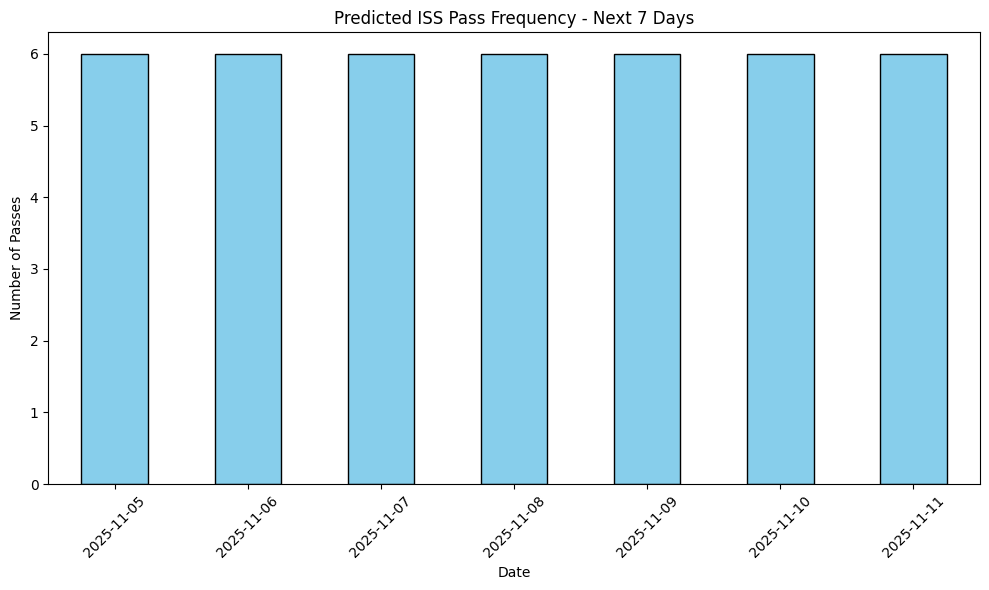

In [37]:
# Create bar chart for previous block
plt.figure(figsize=(10, 6))
daily_passes.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Predicted ISS Pass Frequency - Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Number of Passes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Visualization: Observation Success Rate**

A pie chart showing the success rate of the recorded observations by analyzing the `successful` flag in the merged dataset.

Success Rate Formula: 
```python
success_rate = successful_observations / total_observations

Success rate: 66.7% (2/3 successful)


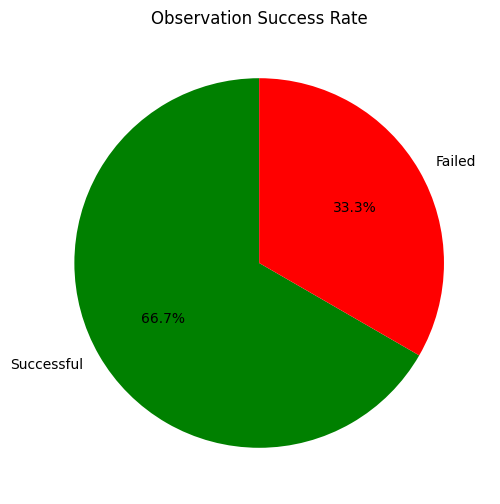

In [38]:
# Visualization: Observation Success Rate

# Calculate success rate based on whether successful flag has an acceptable value.
success_count = merged_df['successful'].sum()
total_observed = merged_df['successful'].notna().sum()
success_rate = success_count / total_observed if total_observed > 0 else 0

print(f"Success rate: {success_rate:.1%} ({success_count}/{total_observed} successful)")

# Create pie chart
if total_observed > 0:
    plt.figure(figsize=(8, 6))
    labels = ['Successful', 'Failed']
    sizes = [success_count, total_observed - success_count]
    colors = ['green', 'red']
    
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Observation Success Rate')
    plt.show()
else:
    print("No observations to visualize")

**Persistence: Save Predictions and Full Data, CSV File Export**

The system saves all ISS tracking data to CSV files for persistence across sessions:

Files Created:

`iss_predictions.csv`
- Contains all ISS pass predictions
- Includes: rise time, max altitude, duration, brightness, and pass IDs

`iss_observations.csv` 
- Contains manual observation logs
- Includes: weather conditions, success status, notes, and actual measurements

`iss_full_data.csv`
- Merged dataset combining predictions with observations
- Enables comprehensive analysis of predicted vs. actual observations

In [39]:
# Save all data to CSV files

# Save predictions
predictions_df.to_csv('iss_predictions.csv', index=False)
print(f"✅ Predictions saved: {len(predictions_df)} passes")

# Save observations
if not observations_df.empty:
    observations_df.to_csv('iss_observations.csv', index=False)
    print(f"✅ Observations saved: {len(observations_df)} records")

# Save merged data
merged_df.to_csv('iss_full_data.csv', index=False)
print(f"✅ Full dataset saved: {len(merged_df)} records")

print("\nFiles created:")
print("  - iss_predictions.csv")
print("  - iss_observations.csv") 
print("  - iss_full_data.csv")

✅ Predictions saved: 42 passes
✅ Observations saved: 3 records
✅ Full dataset saved: 42 records

Files created:
  - iss_predictions.csv
  - iss_observations.csv
  - iss_full_data.csv


**Conclusion and Individual Contribution**
--

---

**Discussion and Interpretation**

This project calculates ISS passing predictions based on ISS TLE data from Celestrack. Based on generated predictions you can edit the code to add in what observations really were based on the pass_id of the prediction you decided to observe. After this part, you can run the rest of the code to see how accurate the predictions were and then see this data in a csv to compare prediction with your actual observations.

**Individual Contribution Statement**

Vivian: Finished observation log down with markdown and comments.